# Sentiment Analysis NPL
> 감성 분석 모델 구축

## 환경 설정

konlpy 설치

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

라이브러리

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<br>
<br>

## 훈련 데이터 이해

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f408b307650>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True) 

In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any') 

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)

In [ ]:
train_data = train_data.dropna(how = 'any')

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "") 
test_data['document'].replace('', np.nan, inplace=True) 
test_data = test_data.dropna(how='any') 
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords] 
    X_train.append(temp_X)

In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) 
    temp_X = [word for word in temp_X if not word in stopwords] 
    X_test.append(temp_X)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

145162
145162


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


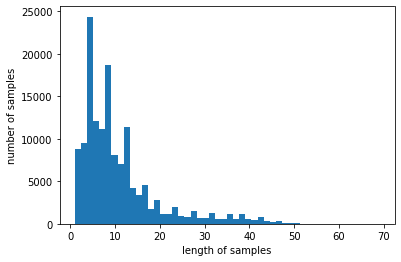

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

<br>
<br>

## LSTM으로 감성 분류

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1936/1936 [==============================] - 175s 88ms/step - loss: 0.3913 - acc: 0.8233 - val_loss: 0.3590 - val_acc: 0.8426

Epoch 00001: val_acc improved from -inf to 0.84263, saving model to best_model.h5
Epoch 2/15
1936/1936 [==============================] - 169s 87ms/step - loss: 0.3275 - acc: 0.8584 - val_loss: 0.3375 - val_acc: 0.8552

Epoch 00002: val_acc improved from 0.84263 to 0.85516, saving model to best_model.h5
Epoch 3/15
1936/1936 [==============================] - 168s 87ms/step - loss: 0.3013 - acc: 0.8720 - val_loss: 0.3304 - val_acc: 0.8582

Epoch 00003: val_acc improved from 0.85516 to 0.85816, saving model to best_model.h5
Epoch 4/15
1936/1936 [==============================] - 169s 87ms/step - loss: 0.2823 - acc: 0.8830 - val_loss: 0.3271 - val_acc: 0.8590

Epoch 00004: val_acc improved from 0.85816 to 0.85895, saving model to best_model.h5
Epoch 5/15
1936/1936 [==============================] - 169s 87ms/step - loss: 0.2653 - acc: 0.8912 - val_loss:

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 20s 13ms/step - loss: 0.3391 - acc: 0.8564

 테스트 정확도: 0.8564


<br>
<br>

## 여행사 리뷰 감성 분석

In [ ]:
AirCanada = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/AirCanada.csv")

AirCanada['review'] = AirCanada['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in AirCanada['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(AirCanada), 2) * 100
print(f'총 {len(AirCanada)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 64개의 리뷰 중 34개의 긍정 리뷰입니다. 긍정리뷰 비율은 53.0 % 입니다.


In [ ]:
AirFrance = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/AirFrance.csv")

AirFrance['review'] = AirFrance['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in AirFrance['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(AirFrance), 2) * 100
print(f'총 {len(AirFrance)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 53개의 리뷰 중 28개의 긍정 리뷰입니다. 긍정리뷰 비율은 53.0 % 입니다.


In [ ]:
AirSeoul = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/AirSeoul.csv")

AirSeoul['review'] = AirSeoul['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in AirSeoul['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(AirSeoul), 2) * 100
print(f'총 {len(AirSeoul)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 69개의 리뷰 중 39개의 긍정 리뷰입니다. 긍정리뷰 비율은 56.99999999999999 % 입니다.


In [ ]:
AmericanAirline = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/AmericanAirline.csv")

AmericanAirline['review'] = AmericanAirline['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in AmericanAirline['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(AmericanAirline), 2) * 100
print(f'총 {len(AmericanAirline)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 43개의 리뷰 중 23개의 긍정 리뷰입니다. 긍정리뷰 비율은 53.0 % 입니다.


In [ ]:
Asiana = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/Asiana.csv")

Asiana['review'] = Asiana['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in Asiana['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(Asiana), 2) * 100
print(f'총 {len(Asiana)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 906개의 리뷰 중 587개의 긍정 리뷰입니다. 긍정리뷰 비율은 65.0 % 입니다.


In [ ]:
ChinaEastern = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/ChinaEastern.csv")

ChinaEastern['review'] = ChinaEastern['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in ChinaEastern['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(ChinaEastern), 2) * 100
print(f'총 {len(ChinaEastern)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 82개의 리뷰 중 30개의 긍정 리뷰입니다. 긍정리뷰 비율은 37.0 % 입니다.


In [ ]:
ChinaSouthern = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/ChinaSouthern.csv")

ChinaSouthern['review'] = ChinaSouthern['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in ChinaSouthern['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(ChinaSouthern), 2) * 100
print(f'총 {len(ChinaSouthern)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 64개의 리뷰 중 25개의 긍정 리뷰입니다. 긍정리뷰 비율은 39.0 % 입니다.


In [ ]:
Delta = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/Delta.csv")

Delta['review'] = Delta['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in Delta['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(Delta), 2) * 100
print(f'총 {len(Delta)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 58개의 리뷰 중 31개의 긍정 리뷰입니다. 긍정리뷰 비율은 53.0 % 입니다.


In [ ]:
Emirates = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/Emirates.csv")

Emirates['review'] = Emirates['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in Emirates['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(Emirates), 2) * 100
print(f'총 {len(Emirates)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 60개의 리뷰 중 35개의 긍정 리뷰입니다. 긍정리뷰 비율은 57.99999999999999 % 입니다.


In [ ]:
JejuAir = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/JejuAir.csv")

JejuAir['review'] = JejuAir['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in JejuAir['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(JejuAir), 2) * 100
print(f'총 {len(JejuAir)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 294개의 리뷰 중 141개의 긍정 리뷰입니다. 긍정리뷰 비율은 48.0 % 입니다.


In [ ]:
JinAir = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/JinAir.csv")

JinAir['review'] = JinAir['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in JinAir['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords]
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(JinAir), 2) * 100
print(f'총 {len(JinAir)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 83개의 리뷰 중 47개의 긍정 리뷰입니다. 긍정리뷰 비율은 56.99999999999999 % 입니다.


In [ ]:
KLM = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/KLM.csv")

KLM['review'] = KLM['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in KLM['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len)
    score = float(loaded_model.predict(pad_new))
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(KLM), 2) * 100
print(f'총 {len(KLM)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 63개의 리뷰 중 31개의 긍정 리뷰입니다. 긍정리뷰 비율은 49.0 % 입니다.


In [ ]:
KoreanAir = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/KoreanAir.csv")

KoreanAir['review'] = KoreanAir['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in KoreanAir['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(KoreanAir), 2) * 100
print(f'총 {len(KoreanAir)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 677개의 리뷰 중 421개의 긍정 리뷰입니다. 긍정리뷰 비율은 62.0 % 입니다.


In [ ]:
LuftHansa = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/LuftHansa.csv")

LuftHansa['review'] = LuftHansa['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in LuftHansa['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(LuftHansa), 2) * 100
print(f'총 {len(LuftHansa)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 97개의 리뷰 중 55개의 긍정 리뷰입니다. 긍정리뷰 비율은 56.99999999999999 % 입니다.


In [ ]:
Qatar = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/Qatar.csv")

Qatar['review'] = Qatar['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in Qatar['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence])
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(Qatar), 2) * 100
print(f'총 {len(Qatar)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 72개의 리뷰 중 45개의 긍정 리뷰입니다. 긍정리뷰 비율은 62.0 % 입니다.


In [ ]:
Tway = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/Tway.csv")

Tway['review'] = Tway['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in Tway['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(Tway), 2) * 100
print(f'총 {len(Tway)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 91개의 리뷰 중 46개의 긍정 리뷰입니다. 긍정리뷰 비율은 51.0 % 입니다.


In [ ]:
United = pd.read_csv("/content/drive/MyDrive/data/항공사리뷰/United.csv")

United['review'] = United['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

positive_cnt = 0
for review in United['review']:
    new_sentence = okt.morphs(review, stem=True) 
    new_sentence = [word for word in new_sentence if not word in stopwords] 
    encoded = tokenizer.texts_to_sequences([new_sentence]) 
    pad_new = pad_sequences(encoded, maxlen = max_len) 
    score = float(loaded_model.predict(pad_new)) 
    if(score > 0.5):
      positive_cnt  += 1
positive_ratio = round(positive_cnt / len(United), 2) * 100
print(f'총 {len(United)}개의 리뷰 중 {positive_cnt}개의 긍정 리뷰입니다. 긍정리뷰 비율은 {positive_ratio} % 입니다.')

총 62개의 리뷰 중 24개의 긍정 리뷰입니다. 긍정리뷰 비율은 39.0 % 입니다.
